In [4]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

## Load data into a Pandas dataframe

In [25]:
cdklm_cuda = (
    ("scripts/laptop/cdklm_cuda_git_versions_laptop_2018_10_11-17_57_28.npz", "840M"),
    ("scripts/met/cdklm_cuda_git_versions_met_2018_10_12-16_18_55.npz", "M2090"),
    ("scripts/abel/cdklm_cuda_git_versions_abel_2018_10_12-18_22_22.npz", "K20"),
    ("scripts/desktop/cdklm_cuda_git_versions_desktop_2018_10_11-16_39_52.npz", "GTX780"),
    ("scripts/amazon_k80/cdklm_cuda_git_versions_amazon_k80_2018_10_12-13_01_04.npz", "K80"),
    ("scripts/amazon_v100/cdklm_cuda_git_versions_amazon_v100_2018_10_12-21_15_12.npz", "V100"),
    #("supercomputer_fermi_cdklm_profiling.npz", "V100")
)

cdklm_opencl = (
    ("scripts/laptop/cdklm_opencl_git_versions_laptop_2018_10_12-15_04_36.npz", "840M"),
    ("scripts/met/cdklm_opencl_git_versions_met_2018_10_12-16_20_14.npz", "M2090"),
    ("scripts/abel/cdklm_opencl_git_versions_abel_2018_10_12-18_23_21.npz", "K20"),
    ("scripts/desktop/cdklm_opencl_git_versions_desktop_2018_10_12-14_58_02.npz", "GTX780"),
    ("scripts/amazon_k80/cdklm_opencl_git_versions_amazon_k80_2018_10_12-13_01_20.npz", "K80"),
    ("scripts/amazon_v100/cdklm_opencl_git_versions_amazon_v100_2018_10_12-21_15_19.npz", "V100"),
)

ctcs_cuda =  (
    ("scripts/laptop/ctcs_cuda_git_versions_laptop_2018_10_11-18_26_56.npz", "840M"),
    ("scripts/met/ctcs_cuda_git_versions_met_2018_10_12-16_22_59.npz", "M2090"),
    ("scripts/abel/ctcs_cuda_git_versions_abel_2018_10_12-18_25_57.npz", "K20"),
    ("scripts/desktop/ctcs_cuda_git_versions_desktop_2018_10_11-17_12_47.npz", "GTX780"),
    ("scripts/amazon_k80/ctcs_cuda_git_versions_amazon_k80_2018_10_12-13_02_19.npz", "K80"),
    ("scripts/amazon_v100/ctcs_cuda_git_versions_amazon_v100_2018_10_12-21_15_50.npz", "V100"),
)
ctcs_opencl =  (
    ("scripts/laptop/ctcs_opencl_git_versions_laptop_2018_10_12-15_03_29.npz", "840M"),
    ("scripts/met/ctcs_opencl_git_versions_met_2018_10_12-16_23_30.npz", "M2090"),
    ("scripts/abel/ctcs_opencl_git_versions_abel_2018_10_12-18_27_02.npz", "K20"),
    ("scripts/desktop/ctcs_opencl_git_versions_desktop_2018_10_12-09_44_56.npz", "GTX780"),
    ("scripts/amazon_k80/ctcs_opencl_git_versions_amazon_k80_2018_10_12-13_02_31.npz", "K80"),
    ("scripts/amazon_v100/ctcs_opencl_git_versions_amazon_v100_2018_10_12-21_15_58.npz", "V100"),
)

fbl_cuda = (
    ("scripts/laptop/fbl_cuda_git_versions_laptop_2018_10_11-18_43_38.npz", "840M"),
    ("scripts/met/fbl_cuda_git_versions_met_2018_10_12-16_25_14.npz", "M2090"),
    ("scripts/abel/fbl_cuda_git_versions_abel_2018_10_12-18_28_39.npz", "K20"),
    ("scripts/desktop/fbl_cuda_git_versions_desktop_2018_10_11-17_13_43.npz", "GTX780"),
    ("scripts/amazon_k80/fbl_cuda_git_versions_amazon_k80_2018_10_12-13_02_55.npz", "K80"),
    ("scripts/amazon_v100/fbl_cuda_git_versions_amazon_v100_2018_10_12-21_16_13.npz", "V100"),
)

fbl_opencl = (
    ("scripts/laptop/fbl_opencl_git_versions_laptop_2018_10_12-15_02_36.npz", "840M"),
    ("scripts/met/fbl_opencl_git_versions_met_2018_10_12-16_25_46.npz", "M2090"),
    ("scripts/abel/fbl_opencl_git_versions_abel_2018_10_12-18_29_51.npz", "K20"),
    ("scripts/desktop/fbl_opencl_git_versions_desktop_2018_10_12-14_56_57.npz", "GTX780"),
    ("scripts/amazon_k80/fbl_opencl_git_versions_amazon_k80_2018_10_12-13_03_06.npz", "K80"),
    ("scripts/amazon_v100/fbl_opencl_git_versions_amazon_v100_2018_10_12-21_16_20.npz", "V100"),
)

In [26]:
def make_df(files):
    #Create column names
    columns = ["labels"]
    for _, label in files:
        columns = columns + ["megacells " + label]

    #Create index names:
    with np.load(files[0][0]) as data:
        index = data['versions']
        labels = data['labels']

    df = pd.DataFrame(columns=columns, index=index)
    df['labels'] = labels

    for filename, label in files:
        with np.load(filename) as data:
            versions = data['versions']
            assert np.all(versions == df.index)
            df["megacells " + label] = data['megacells']

    return df, versions 

Text(0.5,1,'FBL')

<Figure size 432x288 with 0 Axes>

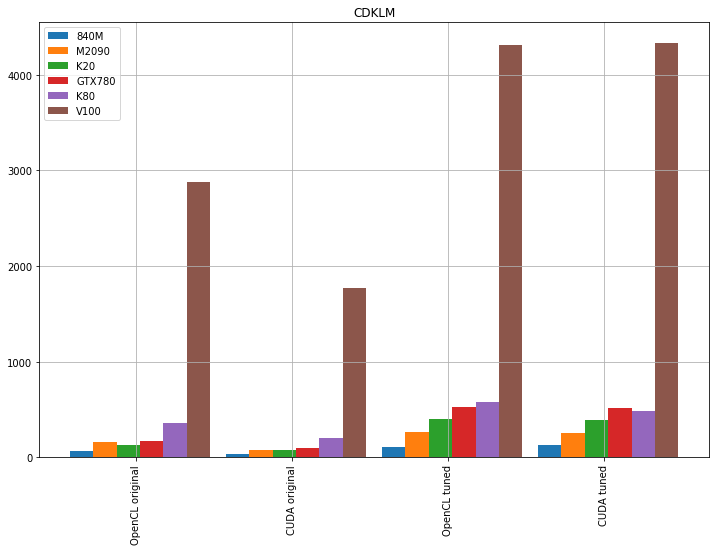

<Figure size 432x288 with 0 Axes>

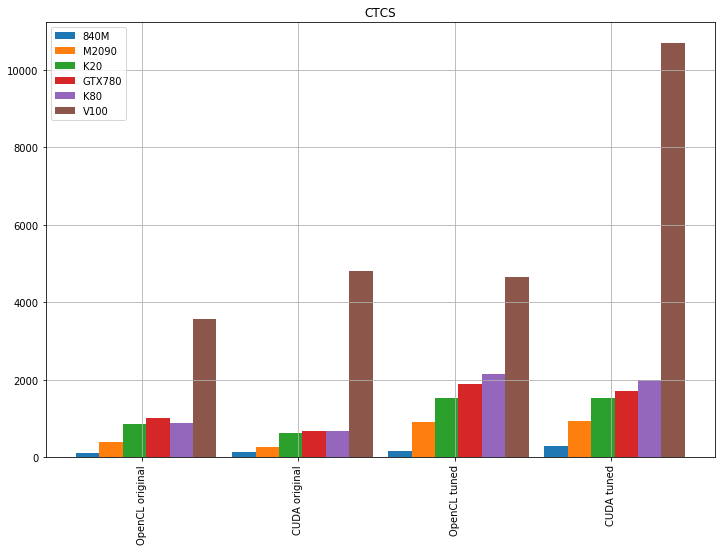

<Figure size 432x288 with 0 Axes>

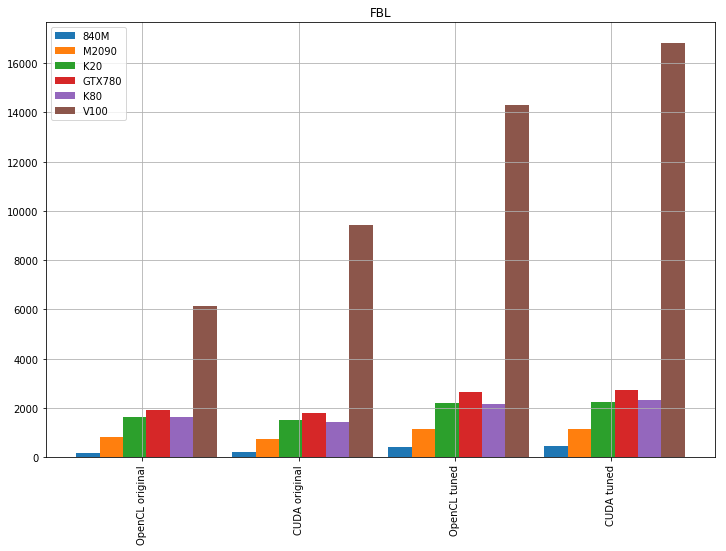

In [27]:
def plot_cuda_vs_opencl_results(opencl_files, cuda_files):
    assert len(opencl_files) == len(cuda_files)
    
    opencl_df, _ = make_df(opencl_files)
    cuda_df, _ = make_df(cuda_files)
    
    fig = plt.figure()

    fig, ax = plt.subplots(figsize=(12,8))

    num_bars = len(opencl_files)
    bar_width = 0.9 / num_bars
    bar_offset = 0.05

    x = np.arange(4)
    architectures = list(zip(*opencl_files))[1]
    num_architectures = len(architectures)
    
    #print(opencl_df)
    #print(cuda_df)

    for i, label in enumerate(architectures):
        ocl_values = opencl_df['megacells ' + label]
        cuda_values = cuda_df['megacells ' + label]
        
        normalization = 1;# / ocl_values[0]
        
        ocl_values = ocl_values*normalization
        cuda_values = cuda_values*normalization
        
        values = [ocl_values[0], cuda_values[0], ocl_values[-1], cuda_values[-1]]
        #print(values)
        
        ax.bar(x+2*bar_offset + (i - num_architectures/2)*bar_width, values, bar_width, label=label)

    labels = ["OpenCL original", "CUDA original", "OpenCL tuned", "CUDA tuned"]
    plt.xticks(x, labels, rotation='vertical')
    plt.grid()

    plt.legend()
    

plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda)
plt.title("CDKLM")

plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda)
plt.title("CTCS")

plot_cuda_vs_opencl_results(fbl_opencl, fbl_cuda)
plt.title("FBL")

## Plot results

In [28]:
def plot_results(files, columns=None):
    df, versions = make_df(files)
    fig = plt.figure()

    fig, ax = plt.subplots(figsize=(12,8))

    num_bars = len(files)
    bar_width = 0.9 / num_bars
    bar_offset = 0.05
    
    if (columns == None):
        columns = np.arange(len(versions))

    x = np.arange(len(columns))
    architectures = list(zip(*files))[1]
    num_architectures = len(architectures)

    for i, label in enumerate(architectures):
        values = df['megacells ' + label]
        values = values / values[0] #Normalize
        values = values[columns]
        ax.bar(x+2*bar_offset + (i - num_architectures/2)*bar_width, values, bar_width, label=label)

    plt.xticks(x, df['labels'][columns], rotation='vertical')
    plt.grid()

    plt.legend()

Text(0.5,1,'CDKLM - OpenCL')

<Figure size 432x288 with 0 Axes>

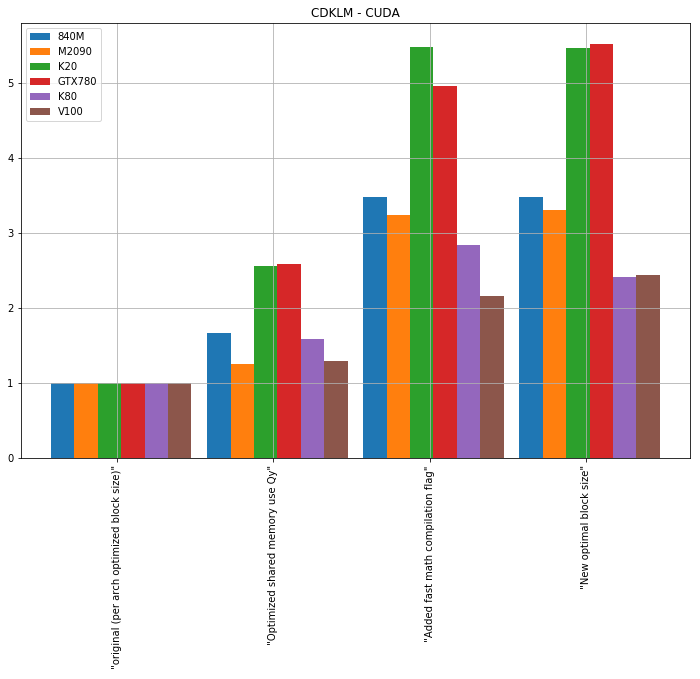

<Figure size 432x288 with 0 Axes>

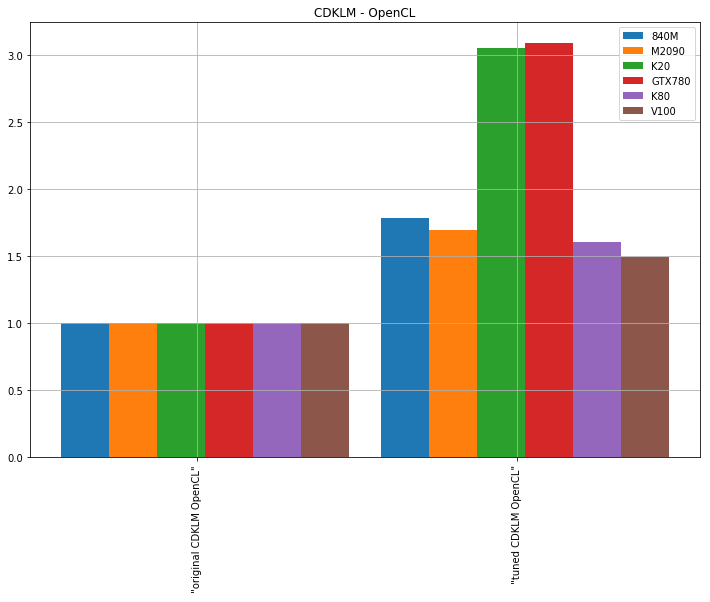

In [29]:
plot_results(cdklm_cuda, columns=[0, 6, 13, 14])
plt.title("CDKLM - CUDA")
plot_results(cdklm_opencl)
plt.title("CDKLM - OpenCL")

Text(0.5,1,'CTCS - OpenCL')

<Figure size 432x288 with 0 Axes>

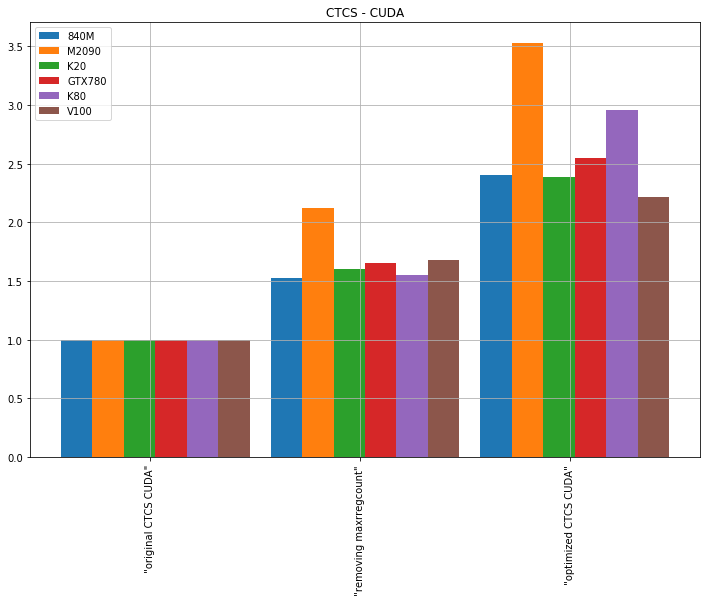

<Figure size 432x288 with 0 Axes>

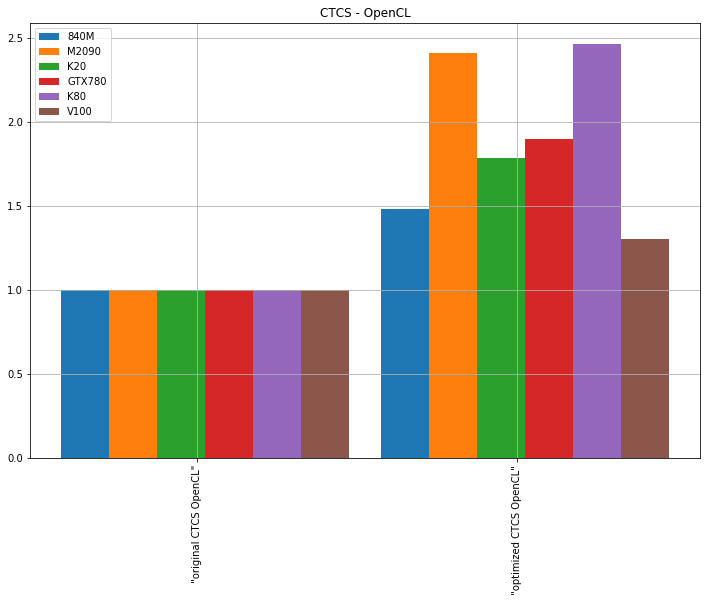

In [30]:
plot_results(ctcs_cuda, columns=[0, 7, 8])
plt.title("CTCS - CUDA")
plot_results(ctcs_opencl)
plt.title("CTCS - OpenCL")

Text(0.5,1,'FBL - OpenCL')

<Figure size 432x288 with 0 Axes>

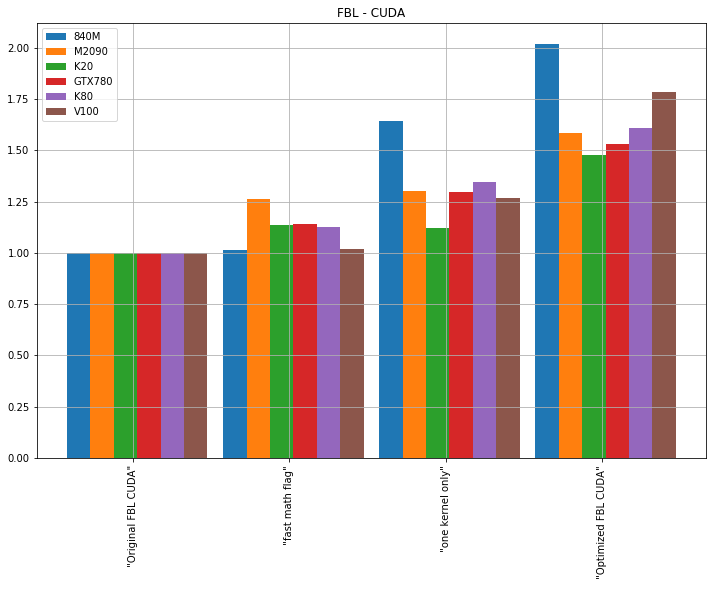

<Figure size 432x288 with 0 Axes>

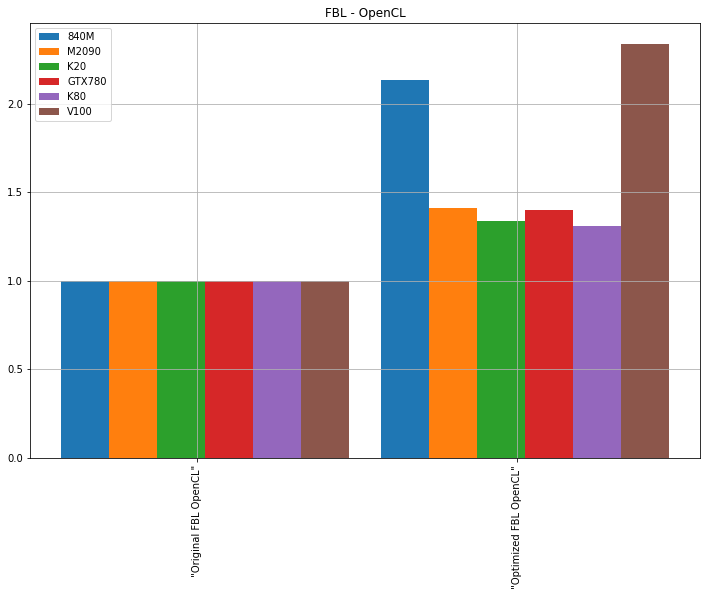

In [31]:
plot_results(fbl_cuda)
plt.title("FBL - CUDA")
plot_results(fbl_opencl)
plt.title("FBL - OpenCL")